## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
os.chdir("drive/My Drive/BTP/NN")

In [ ]:
!ls

Model1.ipynb  Network.py  Neuralnetwork.ipynb  __pycache__  SlidingWindows.py


## Import Modules and Data

In [ ]:
import numpy as np
import pandas as pd
import copy as cp
import pandas as pd
import matplotlib.pyplot as plt
from SlidingWindows import *
from Network import *

In [ ]:
data = pd.read_csv('../data/sales_train_validation.csv')
calender = pd.read_csv('../data/calendar.csv')
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,3,1,3,1,2,2,0,1,1,1,1,0,0,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,3,4,2,1,4,1,3,5,0,6,6,0,0,0,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,3,2,2,2,3,1,0,0,0,0,1,0,4,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


## Analysis for a category in one particular state

In [ ]:
cat_id = "HOBBIES"

state_id_1 = "CA"
category_state = data[(data['cat_id'] == cat_id) & (data['state_id'] == state_id_1)].to_numpy()[:,6:]
category_state.shape
y1 = np.sum(category_state, axis = 0)
print(y1.shape)

state_id_2 = "TX"
category_state = data[(data['cat_id'] == cat_id) & (data['state_id'] == state_id_2)].to_numpy()[:,6:]
category_state.shape
y2 = np.sum(category_state, axis = 0)
print(y2.shape)

state_id_3 = "WI"
category_state = data[(data['cat_id'] == cat_id) & (data['state_id'] == state_id_3)].to_numpy()[:,6:]
category_state.shape
y3 = np.sum(category_state, axis = 0)
print(y3.shape)

(1913,)
(1913,)
(1913,)


In [ ]:
def divide(a, b):
    return np.divide(a, b, out=np.zeros_like(a), where=b!=0)

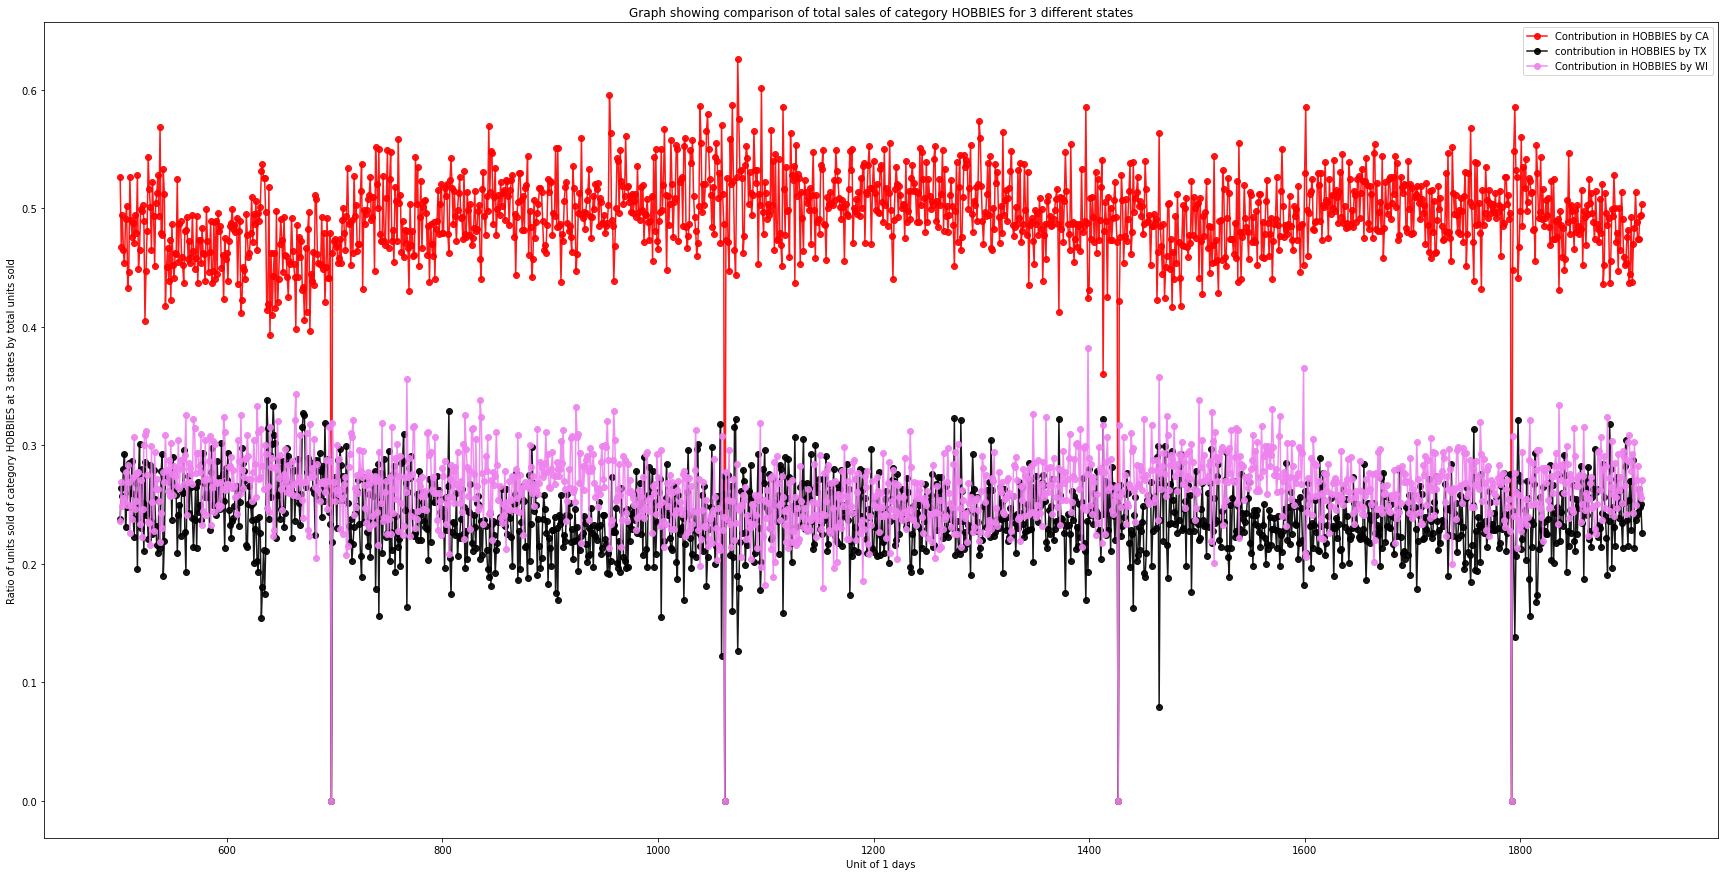

In [ ]:
start = 500
end = 1913
MAX = 1913

distribution_CA = divide(y1, (y1 + y2 + y3))[start:end]
distribution_WI = divide(y2, (y1 + y2 + y3))[start:end]
distribution_TX = divide(y3, (y1 + y2 + y3))[start:end]

t = np.array(range(1, MAX + 1))[start:end]

plt.figure(figsize=(30, 15))

plt.plot(t, distribution_CA,label=f'Contribution in {cat_id} by {state_id_1}',marker='o', c="r", alpha=0.9)
plt.plot(t, distribution_TX,label=f'contribution in {cat_id} by {state_id_2}',marker='o', c="black", alpha=0.9)
plt.plot(t, distribution_WI,label=f'Contribution in {cat_id} by {state_id_3}',marker='o', c="violet", alpha=0.9)

plt.xlabel(f'Unit of 1 days')
plt.ylabel(f'Ratio of units sold of category {cat_id} at 3 states by total units sold')
plt.legend() 
plt.title(f'Graph showing comparison of total sales of category {cat_id} for 3 different states')
plt.show()

## Add events to training set

In [ ]:
calender

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


In [ ]:
calender.event_type_1.dropna().unique()

array(['Sporting', 'Cultural', 'National', 'Religious'], dtype=object)

In [ ]:
for evnt in calender.event_type_1.dropna().unique():
  calender[f'{evnt.lower()}_1'] = [1 if type(i) == str and i == evnt else 0 for i in calender.event_type_1]

for evnt in calender.event_type_1.dropna().unique():
  calender[f'{evnt.lower()}_2'] = [1 if type(i) == str and i == evnt else 0 for i in calender.event_type_2]

calender_train_data = calender.iloc[:,11:][start:end].reset_index(drop=True)
calender_train_data

,snap_CA,snap_TX,snap_WI,sporting_1,cultural_1,national_1,religious_1,sporting_2,cultural_2,national_2,religious_2
0,0,1,1,1,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0
3,0,1,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1408,0,0,0,0,0,0,0,0,0,0,0
1409,0,0,0,0,0,0,0,0,0,0,0
1410,0,0,0,0,0,0,0,0,0,0,0
1411,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
shift = 7
sz = end - start
# t = np.arange(start, end, 1).reshape(-1,1)

previous_days_y = np.array([t])

for s in range(1, shift + 1):
  x1 = np.array([distribution_CA[i-s] if i - s >= 0 else 0 for i in range(0,sz)])
  previous_days_y = np.vstack([previous_days_y, x1])

previous_days_y.shape

(8, 1413)

## Build dataset

In [ ]:
concatenated_data_tuple = tuple(previous_days_y)

dataset = pd.DataFrame(np.transpose(previous_days_y), columns = ['t', 'x1', 'x2', 'x3','x4', 'x5', 'x6', 'x7'])

dataset = pd.concat([dataset, calender_train_data], axis=1)

dataset = dataset.iloc[shift:,:].reset_index(drop=True)

dataset['y1'] = distribution_CA[shift:]
dataset['y2'] = distribution_TX[shift:]
dataset['y3'] = distribution_WI[shift:]

# dataset = dataset.drop(['snap_TX', 'snap_WI', 'y2', 'y3'], axis=1)

dataset


,t,x1,x2,x3,x4,x5,x6,x7,snap_CA,snap_TX,snap_WI,sporting_1,cultural_1,national_1,religious_1,sporting_2,cultural_2,national_2,religious_2,y1,y2,y3
0,508.0,0.501796,0.490946,0.453738,0.464542,0.494400,0.467105,0.526532,0,0,0,0,0,0,0,0,0,0,0,0.432551,0.283725,0.283725
1,509.0,0.432551,0.501796,0.490946,0.453738,0.464542,0.494400,0.467105,0,0,0,0,0,0,0,0,0,0,0,0.446024,0.284672,0.269305
2,510.0,0.446024,0.432551,0.501796,0.490946,0.453738,0.464542,0.494400,0,0,0,1,0,0,0,0,0,0,0,0.526279,0.248073,0.225648
3,511.0,0.526279,0.446024,0.432551,0.501796,0.490946,0.453738,0.464542,0,0,0,0,0,0,0,0,0,0,0,0.490283,0.259856,0.249861
4,512.0,0.490283,0.526279,0.446024,0.432551,0.501796,0.490946,0.453738,0,0,0,0,0,0,0,0,0,0,0,0.475985,0.286638,0.237377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401,1909.0,0.488249,0.513392,0.483402,0.469573,0.437929,0.492868,0.444195,0,0,0,0,0,0,0,0,0,0,0,0.474078,0.243664,0.282258
1402,1910.0,0.474078,0.488249,0.513392,0.483402,0.469573,0.437929,0.492868,0,0,0,0,0,0,0,0,0,0,0,0.474202,0.26275,0.263048
1403,1911.0,0.474202,0.474078,0.488249,0.513392,0.483402,0.469573,0.437929,0,0,0,0,0,0,0,0,0,0,0,0.493268,0.248225,0.258507
1404,1912.0,0.493268,0.474202,0.474078,0.488249,0.513392,0.483402,0.469573,0,0,0,0,0,0,0,0,0,0,0,0.494464,0.250261,0.255275


In [ ]:
dataset = dataset.drop(['snap_TX', 'snap_WI', 'y2', 'y3'], axis=1)
dataset['y'] = [i if i > 0 else 0.5 for i in distribution_CA[shift:]] #remove anomalies for better train

In [ ]:
from sklearn.model_selection import train_test_split
trainset, testset = train_test_split(dataset, test_size = 0.2, shuffle = False)

In [ ]:
w = 5
train_constructor = WindowSlider()
train_windows = train_constructor.collect_windows(trainset.iloc[:,1:], previous_y=False)

test_constructor = WindowSlider()
test_windows = test_constructor.collect_windows(testset.iloc[:,1:], previous_y=False)

train_constructor_y_inc = WindowSlider()
train_windows_y_inc = train_constructor_y_inc.collect_windows(trainset.iloc[:,1:], previous_y=True)

test_constructor_y_inc = WindowSlider()
test_windows_y_inc = test_constructor_y_inc.collect_windows(testset.iloc[:,1:], previous_y=True)

train_windows.head(3)

In [ ]:
##############################################################
# TRAIN THE NETWORK AND PREDICT - Without previous values of y
##############################################################
import time

in_dim = train_windows.shape[1] - 1
NN = Network(input_dim=in_dim, hidden_dim=30, output_dim=1)
t0 = time.time()
eml_residuals = NN.train(x = train_windows.iloc[:,:-1], 
                     y = train_windows.iloc[:,-1].values.reshape(-1,1))
tF = time.time()

fit = NN.predict(train_windows.iloc[:,:-1])
predictions = NN.predict(test_windows.iloc[:,:-1])

eml_fit = cp.deepcopy(fit)
eml_pred = cp.deepcopy(predictions)

eml_residuals = eml_pred - testset.iloc[w:, -1].values.reshape(-1,1)
eml_rmse = np.sqrt(np.sum(np.power(eml_residuals,2)) / len(eml_residuals))
print('RMSE = %.2f' % eml_rmse)
print('Time to train %.2f' % (tF - t0))

In [ ]:
plt.figure(figsize=(30,15))

# lr_y_pred_train = lr_model.predict(trainset.iloc[:,:-1])

plt.plot(testset['t'][5:], testset['y'][5:], alpha=0.7, marker='o', c='b', label="original")
plt.plot(testset['t'][5:], predictions, alpha=0.7, marker='o', c='r', label="prediction")

plt.legend() 
plt.xlabel(f'Unit of 1 days')
plt.ylabel('Total units sold')
# plt.title(f'Graph showing sales of {item_id} for every {r} days')
plt.show()

In [ ]:
fig = plt.figure(figsize=(30,8))
# item_id = "HOBBIES_1_001"
# Histogram for selling price of all items
plt.hist(distribution_CA, bins=1000, color = 'blue', edgecolor='black', range=(0.3, 0.6))

#Histogram for selling price for one particaular item             
# plt.hist(sell_prices.loc[(sell_prices['sell_price'] <= 20.0) & (sell_prices['item_id'] == item_id)]['sell_price'], 
#              bins=80, color = 'blue', edgecolor='black')

plt.title('Histogram of Prices')
plt.xlabel('Prices')
plt.ylabel('Total sale')
plt.show()

In [ ]:
plt.figure(figsize=(30,8))

# lr_y_pred_train = lr_model.predict(trainset.iloc[:,:-1])

plt.plot(testset['t'], testset['y'], alpha=0.7, marker='o', c='b', label="original")
plt.plot(testset['t'][5:], predictions, alpha=0.7, marker='o', c='r', label="prediction")

plt.legend() 
plt.xlabel(f'Unit of 1 days')
plt.ylabel('Total units sold')
# plt.title(f'Graph showing sales of {item_id} for every {r} days')
plt.show()

In [ ]:
###########################################################
# TRAIN THE NETWORK AND PREDICT - With previous values of y
###########################################################

in_dim = train_windows_y_inc.shape[1] - 1
NN = Network(input_dim=in_dim, hidden_dim=30, output_dim=1)
t0 = time.time()
eml_residuals = NN.train(x = train_windows_y_inc.iloc[:,:-1], 
                     y = train_windows_y_inc.iloc[:,-1].values.reshape(-1,1))
tF = time.time()

eml_fit_inc = NN.predict(train_windows_y_inc.iloc[:,:-1])
eml_pred_inc = NN.predict(test_windows_y_inc.iloc[:,:-1])

eml_residuals_inc = eml_pred_inc - testset.iloc[w:, -1].values.reshape(-1,1)
eml_rmse_inc = np.sqrt(np.sum(np.power(eml_residuals_inc,2)) / len(eml_residuals_inc))
print('RMSE = %.2f' % eml_rmse_inc)
print('Time to train %.2f' % (tF - t0))

In [ ]:
plt.figure(figsize=(30,15))

# lr_y_pred_train = lr_model.predict(trainset.iloc[:,:-1])

plt.plot(testset['t'], testset['y'], alpha=0.7, marker='o', c='b', label="original")
plt.plot(testset['t'][5:], eml_pred_inc, alpha=0.9, marker='o', c='black', label="prediction with y")
# plt.plot(testset['t'][5:], predictions, alpha=0.7, marker='o', c='r', label="prediction without y")

plt.legend() 
plt.xlabel(f'Unit of 1 days')
plt.ylabel('Total units sold')
# plt.title(f'Graph showing sales of {item_id} for every {r} days')
plt.show()

In [ ]:
prices = pd.read_csv('../data/sell_prices.csv')

In [ ]:
prices
